In [1]:
from pathlib import Path
import shutil

import amici
from amici.petab_import import import_petab_problem
from amici.plotting import plotObservableTrajectories
import matplotlib.pyplot as plt
from more_itertools import one
import numpy as np
import pandas as pd
import petab
from petab.C import (
    ESTIMATE,
    NOMINAL_VALUE,
)
import yaml2sbml

# Optimization
import pypesto.engine
import pypesto.objective
import pypesto.optimize
import pypesto.petab
import pypesto.visualize

# Optimal control
import petab_control
from petab_control import (
    unscale_parameters,
)

# Timecourse as events
import petab_timecourse

# Helpers
def plot(
    x: dict,
    model,
    solver,
    estimate_petab_problem,
    control_petab_problem = None,
):
    model.setParameterById(x)
    rdata = amici.runAmiciSimulation(model, solver)
    fig, ax = plt.subplots()
    ax.scatter(
        estimate_petab_problem.measurement_df[petab.C.TIME],
        estimate_petab_problem.measurement_df[petab.C.MEASUREMENT],
        label='Real measurements for fitting.',
        color='blue',
    )
    if control_petab_problem is not None:
        ax.scatter(
            control_petab_problem.measurement_df[petab.C.TIME],
            control_petab_problem.measurement_df[petab.C.MEASUREMENT],
            label='Target measurements for control.',
            color='orange',
        )
    plotObservableTrajectories(rdata, model=model, ax=ax)
    #ax.axvline(1)
    #ax.axvline(20)
    #ax.axhline(0.5)
    ax.axvspan(0, 20, facecolor='blue', alpha=0.1)
    ax.axvspan(20, 100, facecolor='orange', alpha=0.1)
    ax.set_ylim(0,1)
    return ax

# Plotted time
end_time = 100


# The same optimizer, optimization engine, and number of starts is
# used for both estimation and optimal control, for this toy model.
optimizer = pypesto.optimize.FidesOptimizer()
engine = pypesto.engine.MultiProcessEngine()
n_starts = 8

Engine set up to use up to 8 processes in total. The number was automatically determined and might not be appropriate on some systems.


In [2]:
# Setup PEtab problem
input_path = Path('optimize_then_control')
output_path = Path('output') / 'optimize_then_control'
output_path.mkdir(parents=True, exist_ok=True)
petab_output_path = output_path / 'petab'

if not petab_output_path.exists():
    shutil.copytree(input_path / 'petab', petab_output_path)
    yaml2sbml.yaml2sbml(
        str(input_path / 'model.yaml'),
        str(petab_output_path / 'estimate' / 'model.xml'),
    )
estimate_petab_problem = petab.Problem.from_yaml(
    str(petab_output_path / 'estimate' / 'problem.yaml'),
)

# Optimize estimate problem to estimate patient-specific parameters
## Setup
model_output_path = output_path / 'models'
estimate_model_output_path = model_output_path / 'estimate'
pypesto_petab_importer = pypesto.petab.PetabImporter(
    estimate_petab_problem,
    output_folder=str(estimate_model_output_path),
)
amici_objective = pypesto_petab_importer.create_objective()
fd_objective = pypesto.objective.FD(amici_objective, grad=True)
pypesto_problem = pypesto_petab_importer.create_problem(fd_objective)

Using existing amici model in folder output/optimize_then_control/models/estimate.


In [3]:
## Run
pypesto_result = pypesto.optimize.minimize(
    pypesto_problem,
    engine=engine,
    n_starts=n_starts,
    optimizer=optimizer,
)

Performing parallel task execution on 8 processes.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 7446.61it/s]Using existing amici model in folder output/optimize_then_control/models/estimate.
Using existing amici model in folder output/optimize_then_control/models/estimate.
Using existing amici model in folder output/optimize_then_control/models/estimate.
Using existing amici model in folder output/optimize_then_control/models/estimate.
Using existing amici model in folder output/optimize_then_control/models/estimate.
Using existing amici model in folder output/optimize_then_control/models/estimate.
Using existing amici model in folder output/optimize_then_control/models/estimate.
Executing task 

2021-07-28 20:23:49,132 - fides - INFO -      3 | +3.749E+00 | -4.34E-01 | -4.27E-01 | +9.79E-01 | 1.00E+00 | 3.36E+00 | 3.64E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-06]
2021-07-28 20:23:49,193 - fides - INFO -      4 | +3.683E+00 | -1.97E-02 | -1.72E-02 | +1.00E+00 | 8.92E-01 | 1.58E-01 | 2.19E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-06]
2021-07-28 20:23:49,218 - fides - INFO -      3 | +4.492E+00 | -1.25E-01 | -8.13E-02 | +1.44E+00 | 3.04E-01 | 3.39E-01 | 3.78E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-06]
2021-07-28 20:23:49,231 - fides - INFO -      4 | +3.678E+00 | -3.73E-03 | -2.87E-03 | +1.14E+00 | 2.00E+00 | 9.39E-02 | 1.27E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-08 1.e-05]
Optimal FD delta: [1.e-03 1.e-06]
Optimal FD delta: [1.e-06 1.e-06]
Optimal FD delta: [1.e-07 1.e-06]
Optimal FD delta: [1.e-06 1.e-06]
2021-07-28 20:23:49,

2021-07-28 20:23:49,689 - fides - WARNING - Stopping as function difference 9.92E-09 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
Final fval=3.6768, time=1.0597s, n_fval=10.
Optimal FD delta: [1.e-05 1.e-06]
2021-07-28 20:23:49,705 - fides - INFO -      9 | +3.677E+00 | -1.66E-05 | -1.25E-05 | +1.21E+00 | 8.92E-01 | 1.99E-03 | 1.84E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-07 1.e-06]
2021-07-28 20:23:49,713 - fides - INFO -      9 | +3.677E+00 | -5.39E-05 | -3.93E-05 | +1.22E+00 | 1.00E+00 | 4.36E-03 | 2.95E-02 | 9.96E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-06]
2021-07-28 20:23:49,743 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:23:49,744 - fides - INFO -     10 | +3.677E+00 | -6.97E-08 | -6.58E-08 | +1.06E+00 | 2.00E+00 | 9.37E-05 | 1.71E-03 | 1.00E+00 | 1.00E+00 | nd   |    

<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

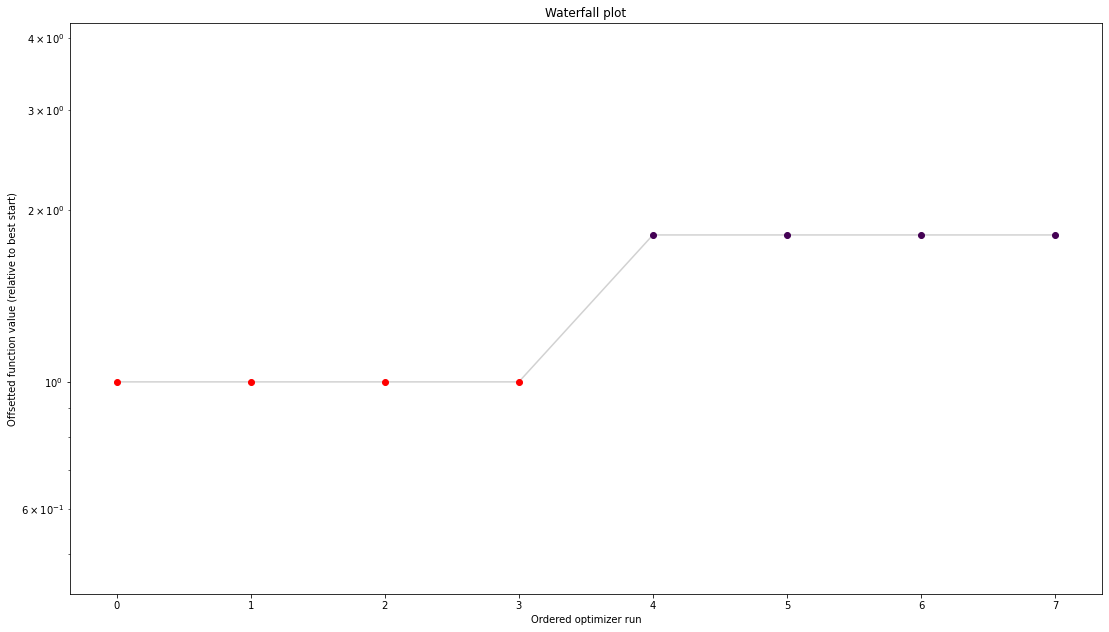

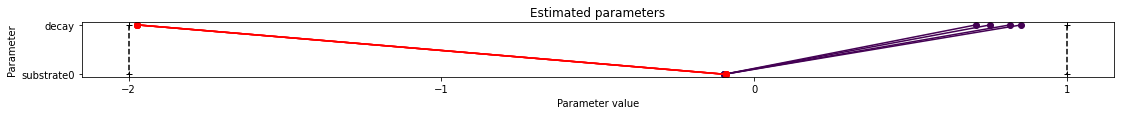

In [4]:
## Plot
### Optimization
pypesto.visualize.waterfall(pypesto_result)
pypesto.visualize.parameters(pypesto_result)

In [5]:
### Fit
scaled_parameters = dict(zip(
    pypesto_problem.x_names,
    pypesto_result.optimize_result.list[0]['x'],
))
unscaled_parameters = \
    unscale_parameters(scaled_parameters, estimate_petab_problem)
# FIXME should not need to do this (i.e. add influx* as events to model...
model0 = amici_objective.amici_model
solver0 = model0.getSolver()
solver0.setMaxSteps(int(1e6))
unscaled_parameters_amici0 = {
    parameter_id: parameter_value
    for parameter_id, parameter_value in unscaled_parameters.items()
    if parameter_id in model0.getParameterIds()
}

model0.setTimepoints(np.linspace(0, end_time, 100*end_time + 1))

In [6]:
# Setup PEtab control problem
control_petab_output_path = output_path / 'control_petab'
control_petab_output_path.mkdir(parents=True, exist_ok=True)

control_problem = petab_control.Problem.from_yaml(
    yaml_path=input_path / 'petab' / 'control' / 'problem.yaml',
    petab_problem=estimate_petab_problem,
)

control_petab_problem = control_problem.get_control_petab_problem()

petab_timecourse.sbml.add_timecourse_as_events(
    control_petab_problem,
    timecourse_id=one(control_petab_problem.timecourse_df.index),
)

petab_control.add_estimate_from_pypesto_result(
    pypesto_result,
    estimate_petab_problem,
    control_petab_problem,
)

control_petab_problem.to_files(
    sbml_file=str(control_petab_output_path / 'model.xml'),
    condition_file=str(control_petab_output_path / 'conditions.tsv'),
    measurement_file=str(control_petab_output_path / 'measurements.tsv'),
    parameter_file=str(control_petab_output_path / 'parameters.tsv'),
    observable_file=str(control_petab_output_path / 'observables.tsv'),
    yaml_file=str(control_petab_output_path / 'problem.yaml'),
)

petab_problem = petab.Problem.from_yaml(
    str(control_petab_output_path / 'problem.yaml'),
)

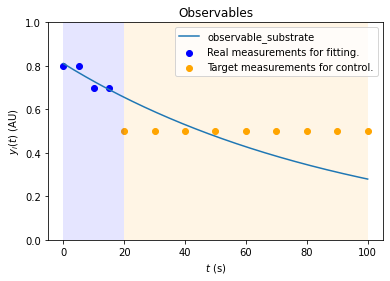

In [7]:
ax = plot(unscaled_parameters_amici0, model0, solver0, estimate_petab_problem, control_petab_problem)

In [8]:
# Optimize
## Setup
control_model_output_path = model_output_path / 'control'
pypesto_petab_importer = pypesto.petab.PetabImporter(
    petab_problem,
    output_folder=str(control_model_output_path),
)
amici_objective = pypesto_petab_importer.create_objective()
fd_objective = pypesto.objective.FD(amici_objective, grad=True)
pypesto_problem = pypesto_petab_importer.create_problem(fd_objective)

Using existing amici model in folder output/optimize_then_control/models/control.


In [9]:
## Estimate control parameters
pypesto_result = pypesto.optimize.minimize(
    pypesto_problem,
    engine=engine,
    n_starts=n_starts,
    optimizer=optimizer,
)

Performing parallel task execution on 8 processes.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 4405.20it/s]Using existing amici model in folder output/optimize_then_control/models/control.
Using existing amici model in folder output/optimize_then_control/models/control.
Using existing amici model in folder output/optimize_then_control/models/control.
Using existing amici model in folder output/optimize_then_control/models/control.
Using existing amici model in folder output/optimize_then_control/models/control.
Using existing amici model in folder output/optimize_then_control/models/control.
Using existing amici model in folder output/optimize_then_control/models/control.
Executing task 5.
Exec

Optimal FD delta: [1.e-06 1.e-08 1.e-06 1.e-06 1.e-05 1.e-05]
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-06 1.e-06 1.e-04]
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-04 1.e-05 1.e-05]
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-06 1.e-05 1.e-05]
Optimal FD delta: [1.e-04 1.e-06 1.e-05 1.e-06 1.e-06 1.e-06]
Optimal FD delta: [1.e-06 1.e-04 1.e-05 1.e-05 1.e-05 1.e-05]
2021-07-28 20:23:52,180 - fides - INFO -      3 | +1.112E+06 | -3.41E+06 | -6.35E+06 | +5.30E-01 | 2.50E-01 | 1.11E+07 | 5.91E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:23:52,202 - fides - INFO -      3 | +1.978E+04 | -8.33E+04 | -1.68E+05 | +4.89E-01 | 2.50E-01 | 3.18E+05 | 5.50E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:23:52,205 - fides - INFO -      3 | +2.197E+03 | -1.12E+04 | -2.58E+04 | +4.29E-01 | 2.50E-01 | 5.11E+04 | 5.34E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:23:52,206 - fides - INFO -      3 | +7.136E+03 | -3.67E+04 | -8.27E+04 | +4.38E-01 

2021-07-28 20:23:53,285 - fides - INFO -      7 | +9.843E+01 | -2.25E+02 | -3.78E+02 | +5.84E-01 | 2.50E-01 | 8.48E+02 | 4.64E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:23:53,288 - fides - INFO -      7 | +2.385E+01 | -3.05E+01 | -4.84E+01 | +6.17E-01 | 2.50E-01 | 1.15E+02 | 4.37E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:23:53,293 - fides - INFO -      7 | +7.233E+03 | -1.68E+04 | -2.80E+04 | +5.91E-01 | 2.50E-01 | 5.54E+04 | 5.21E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:23:53,299 - fides - INFO -      7 | +8.470E+00 | -5.60E-01 | -9.43E-01 | +5.78E-01 | 2.50E-01 | 2.63E+00 | 3.81E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:23:53,312 - fides - INFO -      7 | +8.460E+00 | -5.60E-01 | -9.16E-01 | +5.97E-01 | 2.50E-01 | 2.52E+00 | 3.82E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-06 1.e-08 1.e-06 1.e-05 1.e-06 1.e-06]
2021-07-28 20:23:53,358 - fides - INFO -      7 | +2.

2021-07-28 20:23:54,305 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:23:54,308 - fides - INFO -     10 | +2.081E+01 | -3.06E+01 | -5.04E+01 | +5.94E-01 | 2.50E-01 | 1.19E+02 | 4.42E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-06 1.e-05 1.e-05]
2021-07-28 20:23:54,404 - fides - INFO -     11 | +9.964E+00 | -3.08E+00 | -4.63E+00 | +6.50E-01 | 2.50E-01 | 1.21E+01 | 3.98E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-06 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-05 1.e-05 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-05 1.e-06 1.e-06]
2021-07-28 20:23:54,443 - fides - INFO -     11 | +8.287E+00 | +2.18E-05 | -6.11E-04 | -4.87E-02 | 6.25E-02 | 7.53E-03 | 8.28E-02 | 9.89E-01 | 1.00E+00 | 

Optimal FD delta: [1.e-05 1.e-06 1.e-05 1.e-05 1.e-06 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
Optimal FD delta: [1.e-06 1.e-05 1.e-06 1.e-06 1.e-06 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:23:55,635 - fides - INFO -     15 | +8.297E+00 | -3.54E-02 | -6.22E-02 | +5.58E-01 | 2.50E-01 | 1.97E-01 | 3.32E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:23:55,645 - fides - INFO -     15 | +8.287E+00 | -5.67E-05 | -6.94E-05 | +8.17E-01 | 7.81E-03 | 6.86E-03 | 1.02E-02 | 9.93E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-05 1.e-06 1.e-06]
2021-07-28 20:23:55,659 - fides - INFO -     15 | +8.290E+00 | -1.29E-04 | -2.25E-04 | +5.69E-01 | 1.56E-02 | 8.54E-03 | 3.46E-02 | 9.74E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:23:55,663 - fides - INFO -     15 | +9.559E+00 | -2.36E+00 | -3.55E+00 | +6.50E-01 

Optimal FD delta: [1.e-06 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:23:56,816 - fides - INFO -     19 | +8.290E+00 | +9.30E-04 | -9.17E-04 | -1.05E+00 | 6.25E-02 | 8.64E-03 | 1.39E-01 | 9.72E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-05 1.e-06 1.e-06]
2021-07-28 20:23:56,853 - fides - INFO -     19 | +8.294E+00 | -2.33E-02 | -4.37E-02 | +5.25E-01 | 2.50E-01 | 1.41E-01 | 3.27E-01 | 9.50E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-06 1.e-05 1.e-05 1.e-08 1.e-06]
2021-07-28 20:23:56,899 - fides - INFO -     19 | +8.290E+00 | -1.77E-04 | -2.23E-04 | +7.92E-01 | 1.56E-02 | 9.48E-03 | 3.20E-02 | 9.73E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-06 1.e-06]
2021-07-28 20:23:56,960 - fides - INFO -     19 | +8.288E+00 | -1.81E-04 | -3.22E-04 | +5.60E-01 | 1.56E-02 | 8.23E-03 | 3.94E-02 | 9.58E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-06 1.e-05 1.e-06 1.e-

2021-07-28 20:23:57,868 - fides - INFO -     22 | +8.287E+00 | +9.75E-06 | -4.92E-05 | -2.05E-01 | 1.56E-02 | 1.73E-03 | 3.68E-02 | 9.93E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-08 1.e-05 1.e-05 1.e-06 1.e-07 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-08 1.e-06 1.e-07]
2021-07-28 20:23:57,907 - fides - INFO -     23 | +8.288E+00 | -1.67E-05 | -3.67E-05 | +4.53E-01 | 7.81E-03 | 3.62E-03 | 1.53E-02 | 9.94E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:23:57,918 - fides - INFO -     23 | +8.289E+00 | -6.09E-05 | -5.03E-04 | +8.96E-02 | 6.25E-02 | 6.75E-03 | 1.03E-01 | 9.89E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-08 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-06 1.e-08 1.e-06]
2021-07-28 20:23:57,959 - fides - INFO -     23 | +8.287E+00 | -3.36E-06 | -5.90E-06 | +5.70E-01 | 3.91E-03 | 1.26E-03 | 5.02E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:23:57,962 - fides - INFO -    

2021-07-28 20:23:59,075 - fides - INFO -     27 | +8.288E+00 | +8.15E-05 | -2.26E-04 | -3.92E-01 | 6.25E-02 | 3.61E-03 | 6.79E-02 | 9.97E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-06 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:23:59,106 - fides - INFO -     27 | +8.289E+00 | -1.94E-04 | -2.05E-04 | +9.36E-01 | 3.12E-02 | 6.17E-03 | 3.66E-02 | 9.94E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:23:59,129 - fides - INFO -     27 | +8.289E+00 | -4.52E-05 | -4.57E-05 | +9.86E-01 | 7.81E-03 | 5.48E-03 | 9.28E-03 | 9.94E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
2021-07-28 20:23:59,160 - fides - INFO -     27 | +8.289E+00 | +6.61E-04 | -4.32E-04 | -1.58E+00 | 6.25E-02 | 5.41E-03 | 1.17E-01 | 9.89E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-06 1.e-08 1.e-07 1.e-07 1.e-07 1.e-07]
2021-07-28 20:23:59,263 - fides - INFO -    

2021-07-28 20:24:00,106 - fides - INFO -     30 | +8.287E+00 | -1.70E-06 | -5.17E-06 | +3.29E-01 | 3.91E-03 | 1.10E-03 | 8.39E-03 | 9.97E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-06 1.e-05 1.e-05 1.e-06 1.e-07 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:00,151 - fides - INFO -     31 | +8.289E+00 | -4.11E-05 | -7.10E-05 | +5.78E-01 | 7.81E-03 | 5.16E-03 | 1.80E-02 | 9.82E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:00,155 - fides - INFO -     31 | +8.289E+00 | -6.43E-05 | -6.55E-05 | +9.74E-01 | 1.56E-02 | 4.24E-03 | 1.58E-02 | 9.96E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:00,153 - fides - INFO -     31 | +8.289E+00 | +1.86E-03 | -5.15E-04 | -3.76E+00 | 1.25E-01 | 4.00E-03 | 1.87E-01 | 9.96E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-06 1.e-05 1.e-05 1.e-05 1.e-07 1.e-06]
Optimal FD delta: [1.e-07 1.e-05 1.e-05 1.e-06 1.e-08 1.e-07]
2021-07-28 20:24:00,251 - fides - INFO -    

2021-07-28 20:24:01,412 - fides - INFO -     35 | +8.287E+00 | -7.36E-07 | -1.00E-06 | +7.34E-01 | 9.77E-04 | 9.91E-04 | 2.03E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:01,420 - fides - INFO -     36 | +8.288E+00 | +1.32E-05 | -8.69E-05 | -1.57E-01 | 1.56E-02 | 3.93E-03 | 3.26E-02 | 9.91E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-05 1.e-05 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:01,449 - fides - INFO -     36 | +8.288E+00 | -9.96E-05 | -1.03E-04 | +9.57E-01 | 3.12E-02 | 3.47E-03 | 3.10E-02 | 9.97E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:01,479 - fides - INFO -     36 | +8.288E+00 | -2.31E-05 | -2.55E-05 | +9.06E-01 | 3.91E-03 | 5.62E-03 | 4.75E-03 | 9.94E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:01,518 - fides - INFO -     36 | +8.288E+00 | -1.85E-05 | -3.11E-05 | +5.90E-01 | 7.81E-0

2021-07-28 20:24:02,496 - fides - INFO -     40 | +8.288E+00 | -1.41E-05 | -3.14E-05 | +4.45E-01 | 7.81E-03 | 3.35E-03 | 1.43E-02 | 9.95E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-06 1.e-07 1.e-05 1.e-06 1.e-07]
2021-07-28 20:24:02,554 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:02,556 - fides - INFO -     40 | +8.288E+00 | +1.51E-04 | -2.53E-04 | -6.30E-01 | 6.25E-02 | 3.87E-03 | 7.10E-02 | 9.97E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:02,606 - fides - INFO -     41 | +8.288E+00 | -1.46E-05 | -1.89E-05 | +7.72E-01 | 7.81E-03 | 2.52E-03 | 8.14E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-05 1.e-06 1.e-06]
2021-07-28 20:24:02,678 - fides - INFO 

Optimal FD delta: [1.e-05 1.e-06 1.e-07 1.e-05 1.e-06 1.e-07]
2021-07-28 20:24:03,749 - fides - INFO -     45 | +8.288E+00 | -7.64E-06 | -8.19E-06 | +9.31E-01 | 3.91E-03 | 2.33E-03 | 3.70E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:03,766 - fides - INFO -     44 | +8.287E+00 | -1.13E-06 | -1.13E-06 | +9.96E-01 | 1.95E-03 | 9.11E-04 | 1.32E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:03,782 - fides - INFO -     45 | +8.288E+00 | -3.96E-05 | -7.42E-05 | +5.32E-01 | 1.56E-02 | 4.25E-03 | 1.86E-02 | 9.96E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-06 1.e-08 1.e-06]
2021-07-28 20:24:03,818 - fides - INFO -     45 | +8.288E+00 | -2.05E-05 | -2.07E-05 | +9.87E-01 | 7.81E-03 | 2.89E-03 | 7.26E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-06 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:03,893 - fides - INFO -    

Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:04,959 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:04,961 - fides - INFO -     50 | +8.288E+00 | -1.72E-05 | -1.73E-05 | +9.88E-01 | 7.81E-03 | 2.50E-03 | 7.10E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:04,964 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:04,966 - fides - INFO -     50 | +8.288E+00 | -3.39E-05 | -3.80E-05 | +8.83E-01 | 1.56E-02 | 2.67E-03 | 1.59E-02 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-08 1.e-06 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-08 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:05,006 - fides - 

2021-07-28 20:24:06,080 - fides - INFO -     55 | +8.288E+00 | -1.14E-05 | -2.08E-05 | +5.49E-01 | 3.91E-03 | 2.87E-03 | 9.32E-03 | 9.90E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-08 1.e-06 1.e-06 1.e-07 1.e-07 1.e-07]
2021-07-28 20:24:06,102 - fides - INFO -     55 | +8.288E+00 | -3.39E-05 | -6.71E-05 | +4.91E-01 | 3.12E-02 | 2.41E-03 | 2.95E-02 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:06,120 - fides - INFO -     55 | +8.288E+00 | -4.14E-05 | -7.61E-05 | +5.31E-01 | 3.12E-02 | 2.67E-03 | 3.01E-02 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:06,150 - fides - INFO -     55 | +8.288E+00 | -1.11E-05 | -1.36E-05 | +8.13E-01 | 7.81E-03 | 1.99E-03 | 7.27E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-06 1.e-06 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:06,206 - fides - INFO -     55 | +8.288E+00 | -9.79E-05 | -1.15E-04 | +8.20E-01 | 6.25E-0

2021-07-28 20:24:07,241 - fides - INFO -     60 | +8.288E+00 | -2.86E-05 | -6.81E-05 | +4.18E-01 | 1.56E-02 | 3.81E-03 | 1.91E-02 | 9.96E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-06 1.e-06 1.e-05]
2021-07-28 20:24:07,318 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:07,320 - fides - INFO -     60 | +8.288E+00 | +2.72E-06 | -2.47E-05 | -1.20E-01 | 1.56E-02 | 1.80E-03 | 1.99E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-06 1.e-08 1.e-06]
2021-07-28 20:24:07,346 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:07,348 - fides - INFO -     60 | +8.288E+00 | +7.48E-06 | -2.65E-05 | -2.92E-01 | 1.56E-02 | 1.87E-03 | 2.13E-02 | 9.98E-01 | 1.00E+00 | nd  

2021-07-28 20:24:08,531 - fides - INFO -     66 | +8.288E+00 | -1.77E-05 | -2.19E-05 | +7.98E-01 | 1.56E-02 | 1.73E-03 | 1.32E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-07 1.e-05 1.e-08]
2021-07-28 20:24:08,564 - fides - INFO -     66 | +8.288E+00 | -1.75E-05 | -2.37E-05 | +7.28E-01 | 1.56E-02 | 1.83E-03 | 1.50E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-06 1.e-06 1.e-05]
2021-07-28 20:24:08,593 - fides - INFO -     66 | +8.288E+00 | -1.25E-05 | -1.25E-05 | +9.91E-01 | 7.81E-03 | 1.93E-03 | 6.59E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:08,608 - fides - INFO -     66 | +8.288E+00 | -1.45E-05 | -4.60E-05 | +3.11E-01 | 1.56E-02 | 2.80E-03 | 1.80E-02 | 9.97E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-07 1.e-05 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:08,684 - fides - INFO -    

2021-07-28 20:24:09,679 - fides - INFO -     70 | +8.288E+00 | -3.39E-06 | -5.95E-06 | +5.67E-01 | 3.91E-03 | 1.69E-03 | 5.57E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-06 1.e-06 1.e-07 1.e-06 1.e-07]
Optimal FD delta: [1.e-08 1.e-06 1.e-07 1.e-06 1.e-07 1.e-07]
2021-07-28 20:24:09,721 - fides - INFO -     71 | +8.288E+00 | -7.24E-06 | -1.70E-05 | +4.25E-01 | 3.91E-03 | 2.32E-03 | 9.41E-03 | 9.92E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-08 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:09,755 - fides - INFO -     71 | +8.288E+00 | +5.11E-05 | -2.80E-05 | -1.84E+00 | 1.56E-02 | 1.74E-03 | 2.79E-02 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 0
2021-07-28 20:24:09,772 - fides - INFO -     71 | +8.288E+00 | -2.45E-05 | -2.57E-05 | +9.45E-01 | 1.56E-02 | 1.98E-03 | 1.32E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-

Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:11,013 - fides - INFO -     77 | +8.288E+00 | -9.19E-06 | -9.26E-06 | +9.88E-01 | 7.81E-03 | 1.53E-03 | 6.21E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:11,053 - fides - INFO -     76 | +8.288E+00 | -4.69E-06 | -4.75E-06 | +9.86E-01 | 3.91E-03 | 1.56E-03 | 3.15E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-06 1.e-06 1.e-08]
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:11,111 - fides - INFO -     77 | +8.288E+00 | -3.41E-06 | -5.60E-06 | +6.09E-01 | 1.95E-03 | 1.88E-03 | 4.47E-03 | 9.95E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:11,122 - fides - INFO -     77 | +8.288E+00 | -1.19E-05 | -1.20E-05 | +9.88E-01 | 7.81E-03 | 1.87E-03 | 6.71E-03 | 9.99E-01 | 1.00E+00 | nd   

Optimal FD delta: [1.e-04 1.e-06 1.e-05 1.e-05 1.e-05 1.e-08]
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:12,171 - fides - INFO -     81 | +8.288E+00 | -8.90E-06 | -9.01E-06 | +9.83E-01 | 7.81E-03 | 1.50E-03 | 6.15E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:12,187 - fides - INFO -     82 | +8.288E+00 | -2.23E-06 | -2.33E-06 | +9.55E-01 | 1.95E-03 | 1.50E-03 | 1.65E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-06 1.e-06 1.e-06]
Optimal FD delta: [1.e-06 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:12,240 - fides - INFO -     82 | +8.288E+00 | +3.17E-05 | -3.83E-05 | -8.53E-01 | 3.12E-02 | 1.53E-03 | 3.44E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 0
2021-07-28 20:24:12,258 - fides - INFO -     82 | +8.288E+00 | -2.84E-06 | -2.89E-06 | +9.83E-01 | 1.95E-03 | 1.80E-03 | 1.65E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-

Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-06 1.e-06 1.e-07]
2021-07-28 20:24:13,436 - fides - INFO -     87 | +8.288E+00 | -3.75E-06 | -4.25E-06 | +8.80E-01 | 3.91E-03 | 1.39E-03 | 3.32E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-08 1.e-06 1.e-06 1.e-05 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-07 1.e-05 1.e-06]
2021-07-28 20:24:13,533 - fides - INFO -     88 | +8.288E+00 | -7.93E-06 | -8.03E-06 | +9.83E-01 | 7.81E-03 | 1.38E-03 | 5.87E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:13,558 - fides - INFO -     88 | +8.288E+00 | -4.44E-06 | -4.48E-06 | +9.89E-01 | 3.91E-03 | 1.49E-03 | 3.02E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:13,585 - fides - INFO -     87 | +8.288E+00 | -4.21E-06 | -4.22E-06 | +9.96E-01 | 3.91E-03 | 1.43E-03 | 2.98E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-

Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:14,598 - fides - INFO -     92 | +8.288E+00 | -6.67E-06 | -7.47E-06 | +8.87E-01 | 7.81E-03 | 1.30E-03 | 6.36E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-06 1.e-05 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-04 1.e-06 1.e-06]
2021-07-28 20:24:14,669 - fides - INFO -     93 | +8.288E+00 | -4.05E-06 | -4.53E-06 | +8.91E-01 | 3.91E-03 | 1.47E-03 | 3.34E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:14,680 - fides - INFO -     93 | +8.288E+00 | -6.68E-06 | -1.63E-05 | +4.10E-01 | 7.81E-03 | 1.96E-03 | 9.35E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:14,692 - fides - INFO -     92 | +8.288E+00 | -1.43E-06 | -3.08E-06 | +4.64E-01 | 1.95E-03 | 1.42E-03 | 3.93E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-

2021-07-28 20:24:15,861 - fides - INFO -     98 | +8.288E+00 | -5.51E-07 | -4.75E-06 | +1.14E-01 | 3.91E-03 | 1.33E-03 | 6.58E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:15,887 - fides - INFO -     97 | +8.288E+00 | +1.89E-05 | -1.99E-05 | -9.51E-01 | 7.81E-03 | 1.58E-03 | 1.84E-02 | 9.95E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-06 1.e-05 1.e-06 1.e-05 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-06 1.e-08 1.e-06]
2021-07-28 20:24:15,964 - fides - INFO -     99 | +8.288E+00 | +2.87E-06 | -1.98E-05 | -1.54E-01 | 1.56E-02 | 1.46E-03 | 1.61E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 0
2021-07-28 20:24:15,966 - fides - INFO -     98 | +8.287E+00 | -4.97E-06 | -8.21E-06 | +6.01E-01 | 7.81E-03 | 1.33E-03 | 7.06E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:15,999 - fides - INFO -     99 | +8.288E+00 | -3.96E-06 | -3.99E-06 | +9.90E-01 | 3.91E-0

Optimal FD delta: [1.e-04 1.e-05 1.e-08 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:17,031 - fides - INFO -    103 | +8.288E+00 | -1.48E-06 | -2.06E-06 | +7.19E-01 | 1.95E-03 | 1.29E-03 | 2.63E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:17,036 - fides - INFO -    102 | +8.287E+00 | -8.02E-06 | -1.55E-05 | +5.07E-01 | 1.56E-02 | 1.31E-03 | 1.30E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-08 1.e-06]
2021-07-28 20:24:17,068 - fides - INFO -    103 | +8.287E+00 | -6.18E-06 | -6.85E-06 | +8.97E-01 | 7.81E-03 | 1.22E-03 | 6.16E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-06 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-08 1.e-06]
Optimal FD delta: [1.e-04 1.e-08 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:17,119 - fides - INFO -    104 | +8.287E+00 | -3.38E-06 | -4.78E-06 | +7.05E-01 | 3.91E-03 | 1.41E-03 | 3.99E-03 | 9.99E-01 | 1.00E+00 | nd   

2021-07-28 20:24:18,277 - fides - INFO -    109 | +8.287E+00 | +2.11E-05 | -1.80E-05 | -1.18E+00 | 7.81E-03 | 1.45E-03 | 1.84E-02 | 9.96E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
Optimal FD delta: [1.e-05 1.e-06 1.e-06 1.e-07 1.e-06 1.e-07]
2021-07-28 20:24:18,366 - fides - INFO -    109 | +8.287E+00 | -2.63E-06 | -3.68E-06 | +7.13E-01 | 3.91E-03 | 1.25E-03 | 4.09E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:18,379 - fides - INFO -    109 | +8.287E+00 | -3.04E-06 | -3.72E-06 | +8.13E-01 | 3.91E-03 | 1.25E-03 | 3.39E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:18,383 - fides - INFO -    108 | +8.287E+00 | -2.95E-06 | -3.47E-06 | +8.47E-01 | 3.91E-03 | 1.22E-03 | 3.51E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:18,443 - fides - INFO -   i

Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-08 1.e-05 1.e-06]
2021-07-28 20:24:19,425 - fides - INFO -    114 | +8.287E+00 | +6.49E-07 | -1.58E-05 | -5.05E-02 | 1.56E-02 | 1.27E-03 | 1.47E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-06 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:19,487 - fides - INFO -    114 | +8.287E+00 | -5.82E-06 | -7.08E-06 | +8.17E-01 | 7.81E-03 | 1.23E-03 | 6.15E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
2021-07-28 20:24:19,509 - fides - INFO -    113 | +8.287E+00 | -3.28E-06 | -3.28E-06 | +9.95E-01 | 3.91E-03 | 1.19E-03 | 2.77E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:19,530 - fides - INFO -    114 | +8.287E+00 | -3.19E-06 | -6.62E-06 | +4.76E-01 | 7.81E-03 | 1.16E-03 | 7.70E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-

2021-07-28 20:24:20,730 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:20,732 - fides - INFO -    120 | +8.287E+00 | -2.05E-06 | -4.44E-06 | +4.61E-01 | 1.95E-03 | 1.44E-03 | 4.60E-03 | 9.96E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:20,753 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:20,754 - fides - INFO -    120 | +8.287E+00 | +5.07E-06 | -1.33E-05 | -3.93E-01 | 1.56E-02 | 1.16E-03 | 1.66E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 0
2021-07-28 20:24:20,780 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:20,781 - fides - INFO

2021-07-28 20:24:21,587 - fides - INFO -    123 | +8.287E+00 | -1.84E-06 | -3.43E-06 | +5.35E-01 | 3.91E-03 | 1.16E-03 | 4.57E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-08 1.e-05 1.e-08 1.e-05]
2021-07-28 20:24:21,616 - fides - INFO -    124 | +8.287E+00 | +1.39E-06 | -1.58E-05 | -9.78E-02 | 1.56E-02 | 1.26E-03 | 1.49E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:21,666 - fides - INFO -    124 | +8.287E+00 | -3.24E-06 | -5.27E-06 | +6.14E-01 | 3.91E-03 | 1.43E-03 | 4.41E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-06 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-06 1.e-05 1.e-05]
2021-07-28 20:24:21,717 - fides - INFO -    123 | +8.287E+00 | -4.63E-06 | -1.50E-05 | +3.07E-01 | 7.81E-03 | 1.77E-03 | 9.57E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:21,732 - fides - INFO -    

2021-07-28 20:24:22,904 - fides - INFO -    129 | +8.287E+00 | -9.97E-06 | -1.12E-05 | +8.77E-01 | 1.56E-02 | 1.07E-03 | 1.12E-02 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-08 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:22,927 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:22,928 - fides - INFO -    130 | +8.287E+00 | -6.11E-07 | -8.75E-07 | +6.99E-01 | 9.77E-04 | 1.07E-03 | 1.61E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-06 1.e-08 1.e-06]
2021-07-28 20:24:22,997 - fides - INFO -    131 | +8.287E+00 | +1.08E-07 | -3.53E-06 | -3.27E-02 | 3.91E-03 | 1.10E-03 | 6.05E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:23,005 - fides - INFO 

Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-05 1.e-06 1.e-06]
2021-07-28 20:24:24,179 - fides - INFO -    137 | +8.287E+00 | +3.56E-07 | -3.69E-06 | -9.83E-02 | 3.91E-03 | 1.12E-03 | 6.32E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 0
2021-07-28 20:24:24,188 - fides - INFO -    136 | +8.287E+00 | -2.01E-06 | -4.50E-06 | +4.47E-01 | 1.95E-03 | 1.38E-03 | 4.67E-03 | 9.96E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:24,239 - fides - INFO -    137 | +8.287E+00 | +6.98E-05 | -1.50E-05 | -4.66E+00 | 1.56E-02 | 1.09E-03 | 2.78E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-08 1.e-05 1.e-06 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:24,289 - fides - INFO -    136 | +8.287E+00 | -4.51E-07 | -1.91E-06 | +2.36E-01 | 1.95E-03 | 1.05E-03 | 3.67E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
2021-07-28 20:24:24,314 - fides - INFO -    

Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:25,397 - fides - INFO -    142 | +8.287E+00 | -6.42E-06 | -9.26E-06 | +6.93E-01 | 3.91E-03 | 2.05E-03 | 4.92E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:25,410 - fides - INFO -    143 | +8.287E+00 | -5.18E-06 | -5.58E-06 | +9.23E-01 | 7.81E-03 | 1.06E-03 | 5.45E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:25,498 - fides - INFO -    142 | +8.287E+00 | +1.23E-04 | -2.09E-05 | -5.91E+00 | 1.56E-02 | 1.09E-03 | 3.48E-02 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-06 1.e-06 1.e-07 1.e-06 1.e-06]
2021-07-28 20:24:25,547 - fides - INFO -    143 | +8.287E+00 | +3.18E-06 | -4.55E-06 | -7.00E-01 | 3.91E-03 | 1.06E-03 | 8.27E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-06 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
Optimal FD delta: [1.e-05 1.e-06 1.e-06 1.e-

2021-07-28 20:24:26,781 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:26,782 - fides - INFO -    150 | +8.287E+00 | +8.71E-05 | -1.63E-05 | -5.38E+00 | 1.56E-02 | 1.08E-03 | 3.02E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:26,817 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:26,819 - fides - INFO -    150 | +8.287E+00 | -4.90E-06 | -5.40E-06 | +9.02E-01 | 7.81E-03 | 1.03E-03 | 5.45E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-06 1.e-06 1.e-07 1.e-06 1.e-07]
2021-07-28 20:24:26,849 - fides - INFO -    149 | +8.287E+00 | +5.04E-05 | -1.19E-05 | -4.24E+00 | 1.56E-02 | 9.82E-04 | 2.44E-02 | 9.99E-01 | 1.00E+00 | nd  

Optimal FD delta: [1.e-04 1.e-08 1.e-06 1.e-07 1.e-08 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:27,982 - fides - INFO -    156 | +8.287E+00 | -2.56E-06 | -2.59E-06 | +9.85E-01 | 3.91E-03 | 1.00E-03 | 2.66E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:27,984 - fides - INFO -    155 | +8.287E+00 | -3.61E-06 | -5.16E-06 | +6.95E-01 | 7.81E-03 | 9.81E-04 | 5.89E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-06 1.e-06 1.e-06 1.e-07 1.e-06 1.e-06]
2021-07-28 20:24:28,096 - fides - INFO -    156 | +8.287E+00 | +1.21E-04 | -1.86E-05 | -6.53E+00 | 1.56E-02 | 1.03E-03 | 3.43E-02 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-08 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:28,119 - fides - INFO -    156 | +8.287E+00 | -4.61E-06 | -5.24E-06 | +8.74E-01 | 7.81E-03 | 1.01E-03 | 5.47E-03 | 1.00E+00 | 1.00E+00 | nd   

Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:29,194 - fides - INFO -    161 | +8.287E+00 | +1.36E-05 | -1.40E-05 | -9.88E-01 | 1.56E-02 | 1.08E-03 | 1.66E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:29,243 - fides - INFO -    162 | +8.287E+00 | -3.93E-06 | -4.87E-06 | +8.01E-01 | 7.81E-03 | 9.54E-04 | 5.53E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:29,276 - fides - INFO -    162 | +8.287E+00 | -2.47E-06 | -2.50E-06 | +9.87E-01 | 3.91E-03 | 9.80E-04 | 2.62E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-08 1.e-08 1.e-05 1.e-06 1.e-08 1.e-06]
Optimal FD delta: [1.e-05 1.e-05 1.e-06 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:29,327 - fides - INFO -    163 | +8.287E+00 | -4.76E-06 | -5.30E-06 | +8.93E-01 | 7.81E-03 | 1.02E-03 | 5.45E-03 | 1.00E+00 | 1.00E+00 | nd   

Optimal FD delta: [1.e-04 1.e-05 1.e-08 1.e-06 1.e-05 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
2021-07-28 20:24:30,633 - fides - INFO -    169 | +8.287E+00 | -3.91E-06 | -4.66E-06 | +8.34E-01 | 7.81E-03 | 9.29E-04 | 5.37E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:30,642 - fides - INFO -    168 | +8.287E+00 | -3.33E-06 | -4.77E-06 | +6.93E-01 | 7.81E-03 | 9.32E-04 | 5.75E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-08 1.e-05 1.e-08]
2021-07-28 20:24:30,667 - fides - INFO -    169 | +8.287E+00 | -2.37E-06 | -2.41E-06 | +9.79E-01 | 3.91E-03 | 9.57E-04 | 2.63E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-08]
2021-07-28 20:24:30,700 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:30,701 - fides - INFO 

Optimal FD delta: [1.e-08 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:31,842 - fides - INFO -    174 | +8.287E+00 | +1.98E-06 | -9.72E-06 | -2.16E-01 | 1.56E-02 | 9.20E-04 | 1.30E-02 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 0
2021-07-28 20:24:31,857 - fides - INFO -    175 | +8.287E+00 | -1.17E-06 | -1.17E-06 | +9.98E-01 | 1.95E-03 | 9.38E-04 | 1.25E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-08 1.e-05 1.e-05 1.e-06 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
2021-07-28 20:24:31,904 - fides - INFO -    176 | +8.287E+00 | -1.17E-06 | -1.17E-06 | +9.97E-01 | 1.95E-03 | 9.38E-04 | 1.25E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:31,908 - fides - INFO -    176 | +8.287E+00 | -2.42E-06 | -2.45E-06 | +9.84E-01 | 3.91E-03 | 9.67E-04 | 2.62E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-06 1.e-07 1.e-

2021-07-28 20:24:33,064 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:33,067 - fides - INFO -    180 | +8.287E+00 | -1.98E-06 | -2.12E-06 | +9.32E-01 | 3.91E-03 | 8.75E-04 | 2.66E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-08 1.e-05 1.e-05 1.e-06]
Optimal FD delta: [1.e-05 1.e-06 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:33,127 - fides - INFO -    182 | +8.287E+00 | -5.66E-07 | -5.69E-07 | +9.95E-01 | 9.77E-04 | 9.20E-04 | 6.28E-04 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:33,129 - fides - INFO -    182 | +8.287E+00 | -1.19E-06 | -1.19E-06 | +9.97E-01 | 1.95E-03 | 9.48E-04 | 1.26E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:33,214 - fides - INFO 

2021-07-28 20:24:34,425 - fides - INFO -    188 | +8.287E+00 | -2.77E-06 | -5.46E-06 | +5.06E-01 | 1.95E-03 | 1.37E-03 | 4.83E-03 | 9.95E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:34,457 - fides - INFO -    187 | +8.287E+00 | +4.58E-06 | -4.28E-06 | -1.07E+00 | 3.91E-03 | 9.26E-04 | 8.76E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:34,514 - fides - INFO -    189 | +8.287E+00 | -5.47E-07 | -5.51E-07 | +9.93E-01 | 9.77E-04 | 8.99E-04 | 6.25E-04 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:34,575 - fides - INFO -    189 | +8.287E+00 | -1.14E-06 | -1.15E-06 | +9.97E-01 | 1.95E-03 | 9.26E-04 | 1.24E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-06 1.e-07 1.e-07 1.e-08 1.e-07 1.e-08]
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-

Optimal FD delta: [1.e-08 1.e-05 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:35,660 - fides - INFO -    193 | +8.287E+00 | +2.43E-05 | -1.96E-05 | -1.24E+00 | 7.81E-03 | 1.27E-03 | 1.93E-02 | 9.95E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-08 1.e-06]
2021-07-28 20:24:35,698 - fides - INFO -    195 | +8.287E+00 | -8.06E-07 | -1.41E-06 | +5.72E-01 | 9.77E-04 | 1.01E-03 | 2.29E-03 | 9.97E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:35,757 - fides - INFO -    195 | +8.287E+00 | +4.43E-06 | -4.37E-06 | -1.01E+00 | 3.91E-03 | 9.44E-04 | 8.73E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:35,793 - fides - INFO -    195 | +8.287E+00 | -5.56E-07 | -5.59E-07 | +9.93E-01 | 9.77E-04 | 9.09E-04 | 6.27E-04 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-08 1.e-06 1.e-

2021-07-28 20:24:36,844 - fides - INFO -    201 | +8.287E+00 | -1.46E-06 | -2.09E-06 | +6.97E-01 | 3.91E-03 | 8.57E-04 | 3.33E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:36,956 - fides - INFO -    201 | +8.287E+00 | -7.70E-07 | -1.36E-06 | +5.64E-01 | 9.77E-04 | 1.01E-03 | 2.27E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-05 1.e-06 1.e-06]
Optimal FD delta: [1.e-07 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:36,986 - fides - INFO -    201 | +8.287E+00 | -2.72E-06 | -5.43E-06 | +5.00E-01 | 1.95E-03 | 1.34E-03 | 4.84E-03 | 9.95E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:37,003 - fides - INFO -    201 | +8.287E+00 | +2.57E-05 | -1.78E-05 | -1.45E+00 | 7.81E-03 | 1.21E-03 | 1.92E-02 | 9.96E-01 | 1.00E+00 | nd   |    0 |    0 | 0
2021-07-28 20:24:37,004 - fides - INFO -   i

Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-06 1.e-08 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
2021-07-28 20:24:38,221 - fides - INFO -    208 | +8.287E+00 | +2.64E-05 | -7.82E-06 | -3.38E+00 | 7.81E-03 | 9.04E-04 | 1.71E-02 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 0
2021-07-28 20:24:38,236 - fides - INFO -    208 | +8.287E+00 | -5.08E-07 | -5.37E-07 | +9.46E-01 | 9.77E-04 | 8.60E-04 | 7.27E-04 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:38,260 - fides - INFO -    208 | +8.287E+00 | -7.19E-07 | -9.56E-07 | +7.51E-01 | 1.95E-03 | 8.01E-04 | 1.81E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:38,269 - fides - INFO -    209 | +8.287E+00 | +2.79E-05 | -1.50E-05 | -1.86E+00 | 7.81E-03 | 1.10E-03 | 1.90E-02 | 9.96E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-

2021-07-28 20:24:39,520 - fides - INFO -    216 | +8.287E+00 | -4.83E-07 | -4.99E-07 | +9.66E-01 | 9.77E-04 | 8.32E-04 | 6.63E-04 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-05 1.e-05 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:39,589 - fides - INFO -    216 | +8.287E+00 | -9.76E-07 | -1.14E-06 | +8.59E-01 | 9.77E-04 | 1.16E-03 | 1.18E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:39,598 - fides - INFO -    216 | +8.287E+00 | +1.75E-05 | -1.24E-05 | -1.42E+00 | 1.56E-02 | 9.66E-04 | 1.70E-02 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:39,631 - fides - INFO -    216 | +8.287E+00 | +2.82E-05 | -1.55E-05 | -1.82E+00 | 7.81E-03 | 1.08E-03 | 1.92E-02 | 9.96E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:39,710 - fides - INFO -    

2021-07-28 20:24:40,922 - fides - INFO -    223 | +8.287E+00 | -2.54E-06 | -3.99E-06 | +6.31E-01 | 7.81E-03 | 8.29E-04 | 5.54E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:40,940 - fides - INFO -    224 | +8.287E+00 | -9.32E-07 | -1.09E-06 | +8.54E-01 | 9.77E-04 | 1.13E-03 | 1.18E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:41,038 - fides - INFO -    224 | +8.287E+00 | -7.35E-07 | -9.56E-07 | +7.68E-01 | 1.95E-03 | 8.03E-04 | 1.78E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:41,078 - fides - INFO -    224 | +8.287E+00 | -9.55E-07 | -1.46E-06 | +6.55E-01 | 1.95E-03 | 9.05E-04 | 2.15E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-06 1.e-05 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-08 1.e-06 1.e-06]
2021-07-28 20:24:41,108 - fides - INFO -    

Optimal FD delta: [1.e-04 1.e-05 1.e-07 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:42,379 - fides - INFO -    232 | +8.287E+00 | -6.56E-07 | -9.23E-07 | +7.09E-01 | 1.95E-03 | 7.81E-04 | 1.87E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
2021-07-28 20:24:42,426 - fides - INFO -    231 | +8.287E+00 | -4.65E-07 | -4.93E-07 | +9.43E-01 | 9.77E-04 | 8.14E-04 | 7.11E-04 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-08]
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-08 1.e-06]
2021-07-28 20:24:42,489 - fides - INFO -    232 | +8.287E+00 | +1.88E-06 | -5.03E-06 | -3.80E-01 | 7.81E-03 | 8.47E-04 | 8.16E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 0
2021-07-28 20:24:42,498 - fides - INFO -    232 | +8.287E+00 | +2.75E-05 | -1.64E-05 | -1.68E+00 | 7.81E-03 | 1.12E-03 | 1.92E-02 | 9.96E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-06 1.e-

Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-05 1.e-08]
2021-07-28 20:24:43,865 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:43,866 - fides - INFO -    240 | +8.287E+00 | -4.29E-07 | -1.01E-06 | +4.26E-01 | 9.77E-04 | 8.46E-04 | 2.24E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
2021-07-28 20:24:43,884 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:43,885 - fides - INFO -    240 | +8.287E+00 | +5.23E-06 | -4.09E-06 | -1.28E+00 | 3.91E-03 | 8.57E-04 | 8.94E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-06 1.e-08]
2021-07-28 20:24:43,900 - fides - INFO -    241 | +8.287E+00 | -2.08E-07 | -2.24E-07 | +9.27E-01

2021-07-28 20:24:45,380 - fides - INFO -    251 | +8.287E+00 | -6.87E-07 | -1.72E-06 | +3.97E-01 | 3.91E-03 | 7.49E-04 | 3.66E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:45,403 - fides - INFO -   iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| |  theta   |  alpha   | step | refl | trun | accept
2021-07-28 20:24:45,404 - fides - INFO -    250 | +8.287E+00 | -1.61E-06 | -1.73E-06 | +9.28E-01 | 3.91E-03 | 7.69E-04 | 2.39E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:45,481 - fides - INFO -    251 | +8.287E+00 | -3.01E-07 | -4.84E-07 | +6.20E-01 | 9.77E-04 | 7.60E-04 | 1.35E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-08 1.e-08 1.e-06]
2021-07-28 20:24:45,531 - fides - INFO -    252 | +8.287E+00 | -1.21E-06 | -3.68E-06 | +3.28E-01 | 3.

Optimal FD delta: [1.e-04 1.e-06 1.e-05 1.e-05 1.e-06 1.e-06]
2021-07-28 20:24:46,981 - fides - INFO -    261 | +8.287E+00 | -2.11E-06 | -3.23E-06 | +6.46E-01 | 7.81E-03 | 7.38E-04 | 5.36E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
2021-07-28 20:24:47,011 - fides - INFO -    262 | +8.287E+00 | -2.27E-07 | -4.96E-07 | +4.58E-01 | 9.77E-04 | 7.34E-04 | 1.58E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:47,029 - fides - INFO -    261 | +8.287E+00 | -7.50E-07 | -9.27E-07 | +8.08E-01 | 1.95E-03 | 7.68E-04 | 1.54E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:47,130 - fides - INFO -    262 | +8.287E+00 | +2.40E-06 | -7.86E-06 | -3.09E-01 | 7.81E-03 | 1.03E-03 | 9.47E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-

Optimal FD delta: [1.e-04 1.e-06 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:48,543 - fides - INFO -    271 | +8.287E+00 | -7.90E-07 | -7.90E-07 | +9.99E-01 | 1.95E-03 | 7.32E-04 | 1.08E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:48,621 - fides - INFO -    272 | +8.287E+00 | -5.68E-07 | -1.20E-06 | +4.73E-01 | 9.77E-04 | 8.48E-04 | 2.33E-03 | 9.98E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:48,662 - fides - INFO -    273 | +8.287E+00 | +2.84E-05 | -1.62E-05 | -1.76E+00 | 7.81E-03 | 1.06E-03 | 1.93E-02 | 9.96E-01 | 1.00E+00 | nd   |    0 |    0 | 0
Optimal FD delta: [1.e-04 1.e-05 1.e-05 1.e-05 1.e-05 1.e-06]
2021-07-28 20:24:48,705 - fides - INFO -    272 | +8.287E+00 | -1.57E-06 | -1.57E-06 | +9.95E-01 | 3.91E-03 | 7.29E-04 | 2.17E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-08 1.e-05 1.e-05 1.e-

2021-07-28 20:24:50,124 - fides - WARNING - Stopping as function difference 2.75E-08 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
Final fval=8.2873, time=59.0975s, n_fval=283.
Optimal FD delta: [1.e-05 1.e-05 1.e-05 1.e-05 1.e-06 1.e-06]
2021-07-28 20:24:50,188 - fides - INFO -    283 | +8.287E+00 | -2.78E-07 | -8.04E-07 | +3.44E-01 | 1.95E-03 | 6.98E-04 | 2.33E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-06 1.e-05 1.e-05 1.e-06 1.e-06]
2021-07-28 20:24:50,209 - fides - INFO -    282 | +8.287E+00 | -3.97E-07 | -8.14E-07 | +4.87E-01 | 1.95E-03 | 7.12E-04 | 2.14E-03 | 1.00E+00 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-04 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06]
2021-07-28 20:24:50,309 - fides - INFO -    284 | +8.287E+00 | -7.79E-07 | -1.32E-06 | +5.92E-01 | 1.95E-03 | 8.24E-04 | 2.19E-03 | 9.99E-01 | 1.00E+00 | nd   |    0 |    0 | 1
Optimal FD delta: [1.e-08 1.e-06 1.e-05 1.e-06 1.e-05 1.e-06]
2021-07-28 20:24:50,3

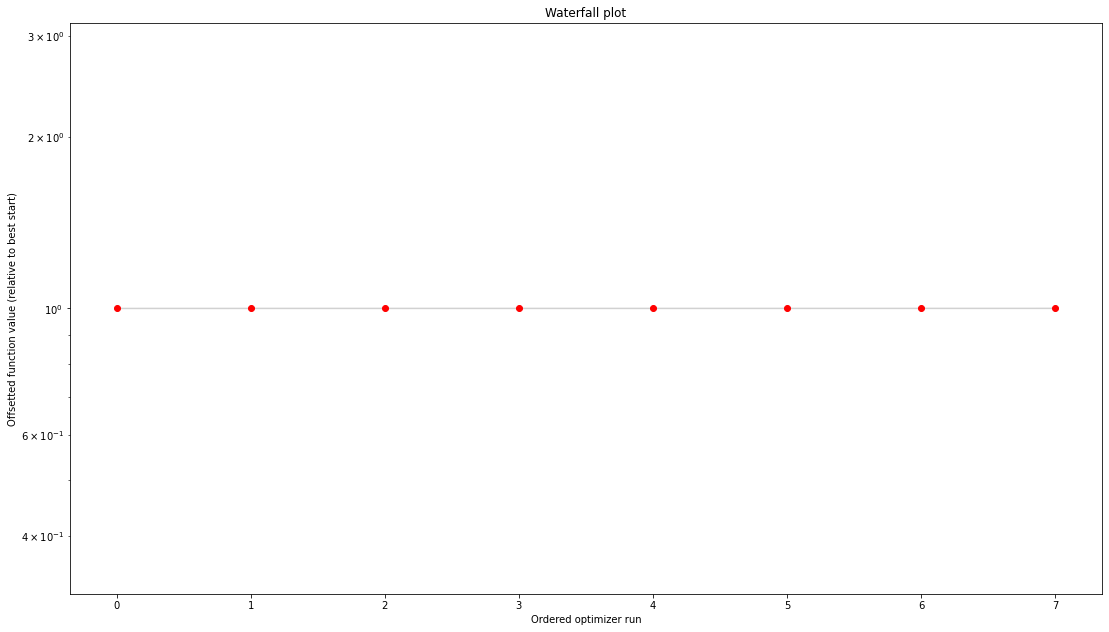

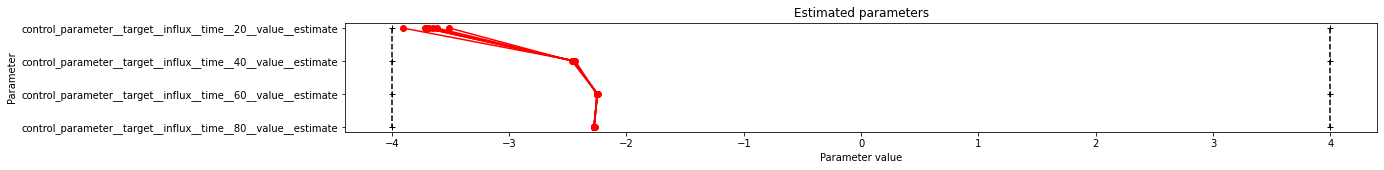

In [10]:
## Plot
### Optimization
pypesto.visualize.waterfall(pypesto_result);
pypesto.visualize.parameters(pypesto_result);

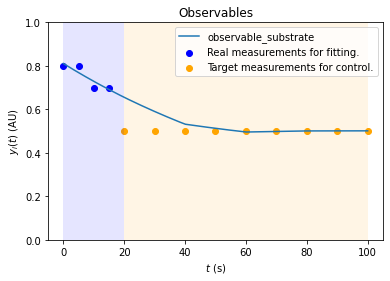

In [11]:
### Fit
scaled_parameters = dict(zip(
    pypesto_problem.x_names,
    pypesto_result.optimize_result.list[0]['x'],
))
unscaled_parameters = unscale_parameters(scaled_parameters, petab_problem)

model = amici_objective.amici_model
solver = model.getSolver()
solver.setMaxSteps(int(1e6))

unscaled_parameters_amici = {
    parameter_id: parameter_value
    for parameter_id, parameter_value in unscaled_parameters.items()
    if parameter_id in amici_objective.amici_model.getParameterIds()
}


model.setTimepoints(np.linspace(0, end_time, 100*end_time + 1))
ax = plot(
    unscaled_parameters_amici,
    model,
    solver,
    estimate_petab_problem,
    control_petab_problem,
)